<a href="https://colab.research.google.com/github/DavideBruni/CIDL_lab/blob/main/CIDL_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Esercizio 1



In [57]:
!pip install vector-quantize-pytorch

In [58]:
import torch
from vector_quantize_pytorch import VectorQuantize


In [59]:
class VQVARAE(torch.nn.Module):
  def __init__(self, input_dim, vector_dim, num_embeddings, codebook_dim, batch_size):
    super(VQVARAE,self).__init__()
    self.batch_size = batch_size
    self.num_embeddings = num_embeddings
    self.vector_dim = vector_dim
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,vector_dim*num_embeddings)
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(vector_dim*num_embeddings, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,input_dim)
    )

    self.vq = VectorQuantize(
        dim = vector_dim,
        codebook_size = codebook_dim,
        decay = 0.8,
        commitment_weight = 1.0
    )

  def encode(self,x):
    return self.encoder(x)

  def decode(self,x):
    return self.decoder(x)

  def forward(self,x):
    latent = self.encoder(x)# from here is flat
    latent = latent.reshape(self.batch_size,self.num_embeddings, self.vector_dim)
    quantized, indices, vq_loss = self.vq(latent)   # here is a matrix
    quantized = quantized.reshape(self.batch_size,self.num_embeddings*self.vector_dim)
    reconstructed = self.decoder(quantized)
    return latent, reconstructed, vq_loss

In [60]:
import torchvision
from tqdm import tqdm
train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)


In [61]:
ae = VQVARAE(784,64,32,16,32)
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
dl = torch.utils.data.DataLoader(train_mnist, batch_size=32,shuffle=True)
ae.to('cpu')

for epoch in range(3):
  bar = tqdm(dl)
  for batch, _ in bar:
    batch = batch.to('cpu')
    batch = batch.reshape(batch.size(0), -1)
    latent, reconstruct, vq_loss = ae(batch)
    error = loss_fn(reconstruct,batch)
    error = error + vq_loss
    optimizer.zero_grad()
    error.backward()
    optimizer.step()

100%|██████████| 1875/1875 [00:40<00:00, 46.37it/s]


torch.Size([32, 1, 28, 28])


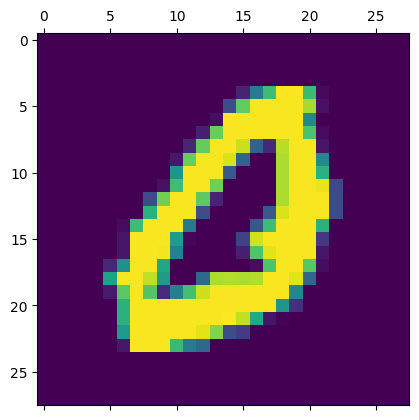

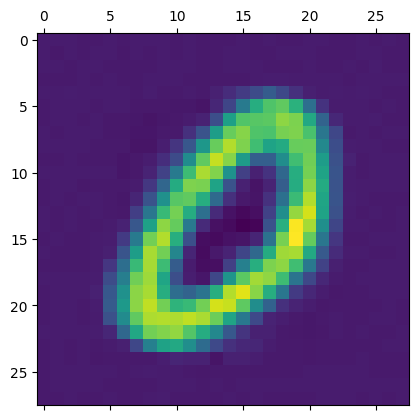

In [62]:
from matplotlib import pyplot as plt
for batch, y in dl:
    print(batch.shape)
    plt.matshow(batch[0].squeeze())
    _,reconstructed_flat,_ = ae(batch.view(32, 28*28))
    reconstructed = reconstructed_flat.view(32, 28, 28)
    plt.matshow(reconstructed[0].detach().numpy())
    break

#Esercizio 2

In [63]:
class HomeMadeVectorQuantize(torch.nn.Module):
  def __init__(self, dim, codebook_size):
    super(HomeMadeVectorQuantize,self).__init__()
    self.vector_dim = dim
    self.codebook_size = codebook_size
    self.codebook = torch.nn.Parameter(torch.rand(codebook_size, dim,requires_grad=True))

  def forward(self,x):
    distances = torch.cdist(x,self.codebook)
    codes = distances.argmin(dim=-1)
    quantized = self.codebook[codes]
    vq = (quantized - x).detach() + x
    commit_loss = torch.nn.functional.mse_loss(x,quantized.detach())
    codebook_loss = torch.nn.functional.mse_loss(x.detach(),quantized)
    loss = commit_loss + codebook_loss

    return vq, codes, loss


In [64]:
class VQVARAE_SECOND_VERSION(torch.nn.Module):
  def __init__(self, input_dim, vector_dim, num_embeddings, codebook_dim, batch_size):
    super(VQVARAE_SECOND_VERSION,self).__init__()
    self.batch_size = batch_size
    self.num_embeddings = num_embeddings
    self.vector_dim = vector_dim
    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,vector_dim*num_embeddings)
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(vector_dim*num_embeddings, 300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,300),
        torch.nn.LeakyReLU(),
        torch.nn.Linear(300,input_dim),
        torch.nn.Sigmoid()
    )

    self.vq = HomeMadeVectorQuantize(
        dim = vector_dim,
        codebook_size = codebook_dim
    )

  def encode(self,x):
    return self.encoder(x)

  def decode(self,x):
    return self.decoder(x)

  def forward(self,x):
    latent = self.encoder(x)# from here is flat
    latent = latent.reshape(self.batch_size,self.num_embeddings, self.vector_dim)
    quantized, indices, vq_loss = self.vq(latent)   # here is a matrix
    quantized = quantized.reshape(self.batch_size,self.num_embeddings*self.vector_dim)
    reconstructed = self.decoder(quantized)
    return latent, reconstructed, vq_loss

In [65]:
train_mnist_2 = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
)

test_mnist_2 = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])
)

In [70]:
ae = VQVARAE_SECOND_VERSION(784,64,32,16,32)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr=0.001)
dl = torch.utils.data.DataLoader(train_mnist_2, batch_size=32,shuffle=True)

for epoch in range(3):
  bar = tqdm(dl)
  for batch, _ in bar:
    batch = batch.reshape(batch.size(0), -1)
    latent, reconstruct, vq_loss = ae(batch)
    error_encoder = loss_fn(reconstruct,batch)
    error = error_encoder + 0.02*vq_loss
    optimizer.zero_grad()
    error.backward()
    optimizer.step()
    bar.set_description(f"Enconder {error_encoder}, vq_error {vq_loss}")

Enconder 0.13620156049728394, vq_error 0.5037397742271423: 100%|██████████| 1875/1875 [00:42<00:00, 44.12it/s]
Enconder 0.11992049962282181, vq_error 0.49475598335266113: 100%|██████████| 1875/1875 [00:42<00:00, 44.40it/s]
Enconder 0.11019189655780792, vq_error 0.45989954471588135: 100%|██████████| 1875/1875 [00:41<00:00, 44.70it/s]


torch.Size([32, 1, 28, 28])


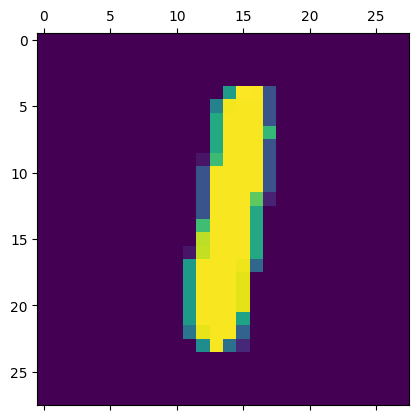

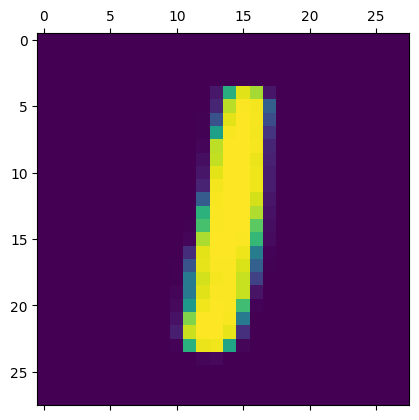

In [74]:
from matplotlib import pyplot as plt
for batch, y in dl:
    print(batch.shape)
    plt.matshow(batch[3].squeeze())
    _,reconstructed_flat,_ = ae(batch.view(32, 28*28))
    reconstructed = reconstructed_flat.view(32, 28, 28)
    plt.matshow(reconstructed[3].detach().numpy())
    break

#Es 3, uguale, ma autoencoder con CNN invece che Linear